# **The Data**

In [157]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, precision_score, cohen_kappa_score, roc_auc_score
from plotnine import *

In [158]:
import warnings
from sklearn.exceptions import ConvergenceWarning
#ignore warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [159]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [160]:
#ha.head()
#ha.describe
#ha.isnull().sum()
#ha.dtypes

# **Part One: Fitting Models**

In [161]:
def cat_roc(modeltype, *args, **argsnum):

  X = ha.drop('output', axis=1)
  y = ha['output']

  # finding the best model

  categorical_features = ['cp', 'restecg','sex']
  numeric_features = ['age', 'trtbps', 'chol', 'thalach']

  ct = ColumnTransformer([
        ('dummify', OneHotEncoder(handle_unknown='ignore'),
        categorical_features),
        ("standardize", StandardScaler(), numeric_features)
    ],
    remainder="passthrough")

  model_pipeline = Pipeline([
        ("preprocessing", ct),
        ("model", modeltype(*args))
    ])

  degree = {'model__' + key: np.array(value) for key, value in argsnum.items()}

  gscv = GridSearchCV(model_pipeline, degree, cv = 5, scoring='roc_auc')

  tuning = gscv.fit(X, y)

  result = pd.DataFrame(tuning.cv_results_).sort_values(by='rank_test_score', ascending=True).head(1)

  # using the best model and getting the confusion matrix

  best_model = tuning.best_estimator_

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  y_pred = best_model.predict_proba(X_test)[:, 1]

  cm = confusion_matrix(y_test, y_pred > 0.5) # Threshold of 0.5 for binary prediction


  fpr, tpr, threshold1 = roc_curve(y_test, y_pred)
  roc_data = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr})

  roc_plot = (
    ggplot(roc_data, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line() +
    geom_abline(slope=1, intercept=0, linetype="dashed") +
    labs(title='ROC Curve', x='False Positive Rate', y='True Positive Rate')+
    xlim(0, 1) +
    ylim(0, 1)
  )

  return result, cm, roc_plot, best_model

## Q1 - KNN

For the model, i played around with different sets of variables, and realized i was getting the best results when including all the variables. After I proceeded to tune the number of nearnest neighbors for the knn model, arriving at the outputs posted below. Our best model achieved a roc_auc score of .82 and was the one with 26 nearnest neighboors.

In [162]:
knn_results, knn_conf_matrix, knn_roc_plot, knn_best_model = cat_roc(KNeighborsClassifier,n_neighbors=[1,3,5,7,9,15,20,26,30])

In [163]:
knn_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       0.014772      0.001266         0.015156        0.004398   

  param_model__n_neighbors                      params  split0_test_score  \
7                       26  {'model__n_neighbors': 26}           0.814667   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
7           0.862069           0.863395           0.878621           0.705517   

   mean_test_score  std_test_score  rank_test_score  
7         0.824854        0.063413                1

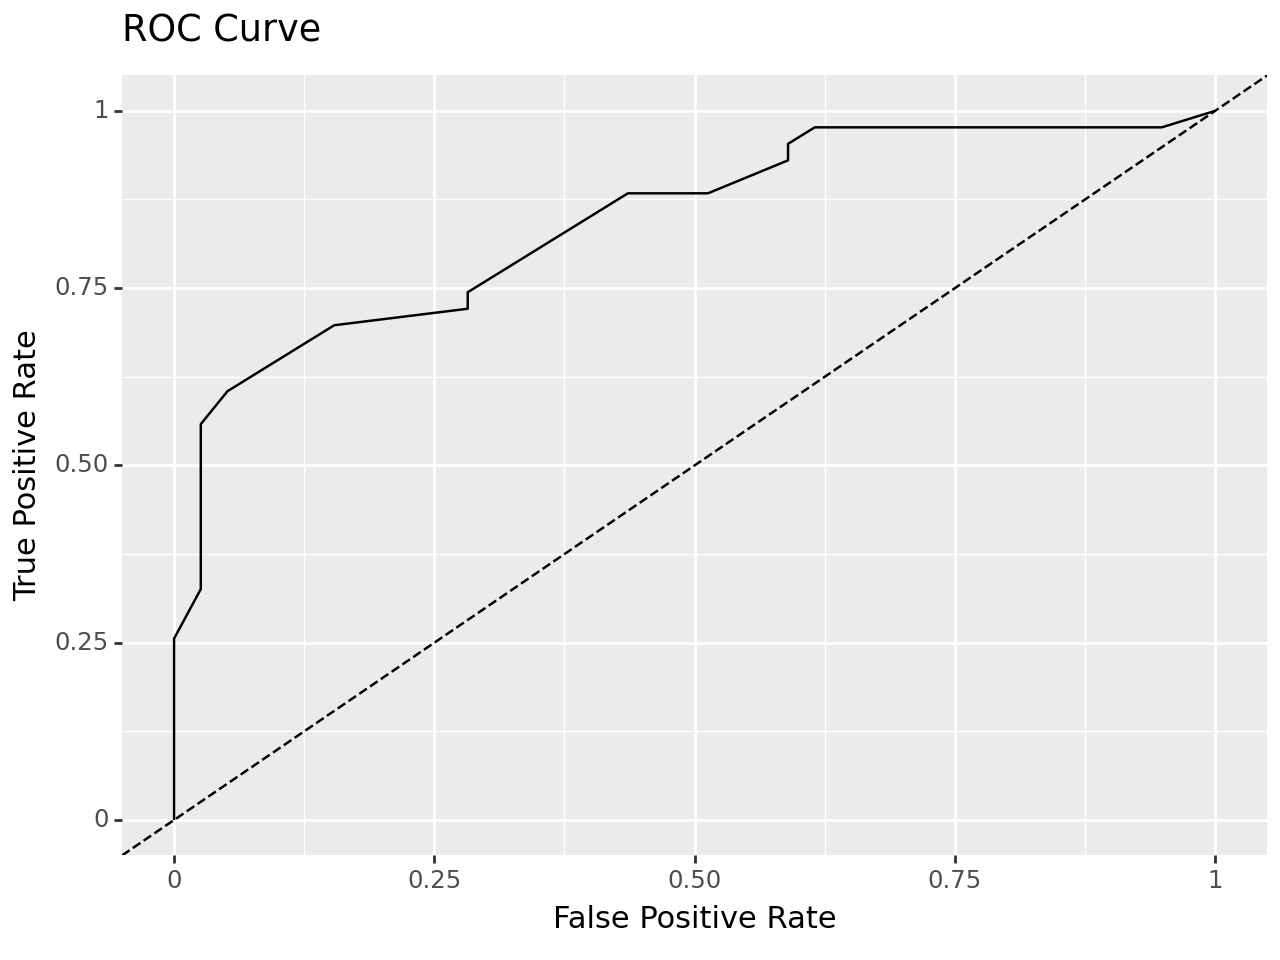

(array([[33,  6],
        [13, 30]]),
 <Figure Size: (640 x 480)>)

In [164]:
knn_conf_matrix, knn_roc_plot

## Q2 - Decision tree

same process was done for the decision tree model. I first decided to use all the variable and then tuned the max depth as well as the min samples leaf. I arrived at a model with a mean roc_auc score of .819 where max depth was 3 and the min samples leaf was 10.

In [165]:
dt_results, dt_conf_matrix, dt_roc_plot, dt_best_model =cat_roc(DecisionTreeClassifier, max_depth = [1,2,3,4], min_samples_leaf = [1,3,5,10,20,50])

In [166]:
dt_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15       0.009377        0.0022         0.006758         0.00163   

   param_model__max_depth param_model__min_samples_leaf  \
15                      3                            10   

                                               params  split0_test_score  \
15  {'model__max_depth': 3, 'model__min_samples_le...           0.828667   

    split1_test_score  split2_test_score  split3_test_score  \
15           0.840186           0.791777           0.885517   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
15           0.748966         0.819022        0.046071                1

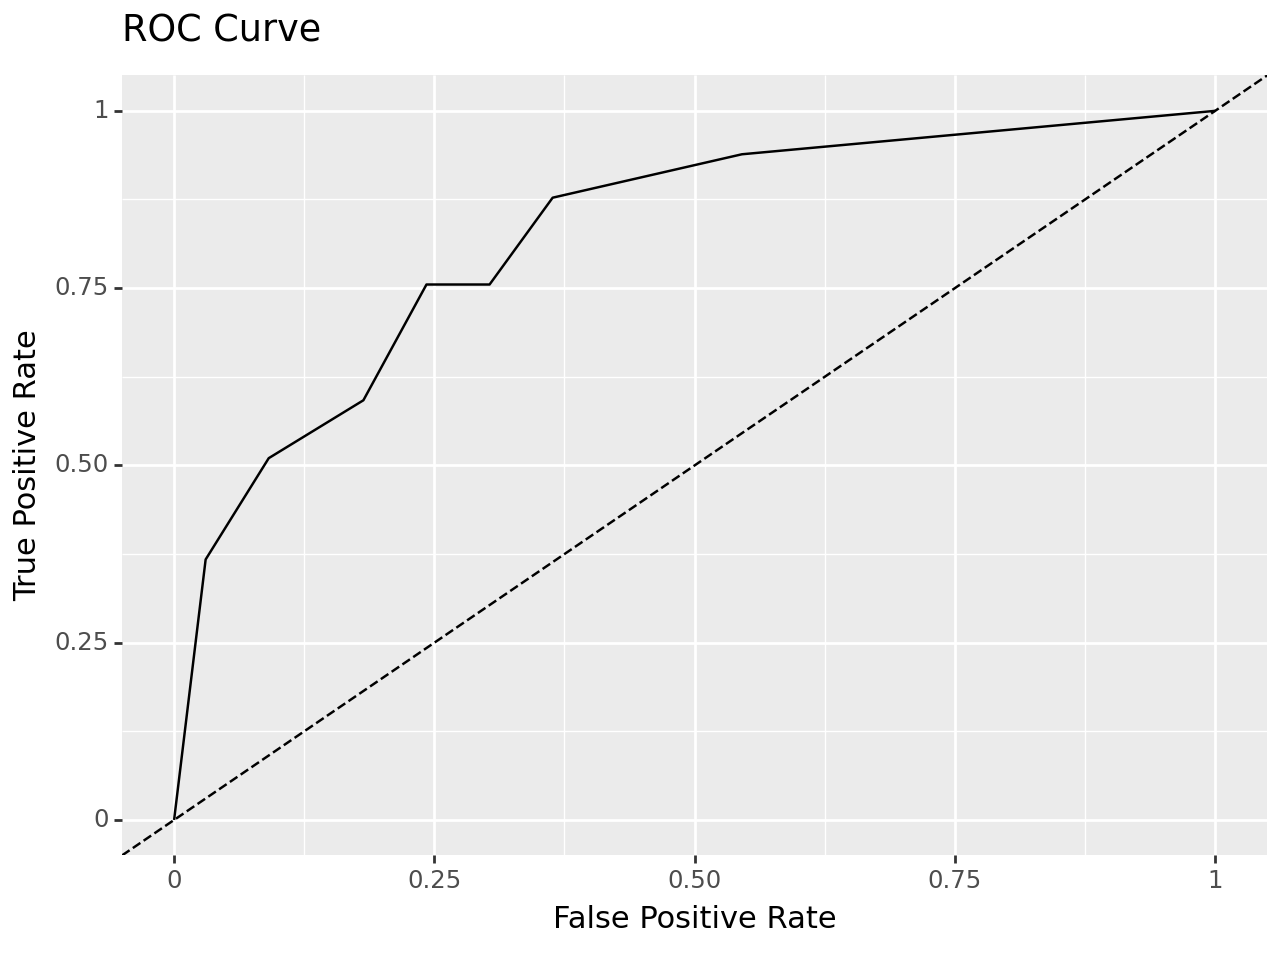

(array([[25,  8],
        [12, 37]]),
 <Figure Size: (640 x 480)>)

In [167]:
dt_conf_matrix, dt_roc_plot

## Q3 - Logistic Regression

Similar to both models above, we used all the variables. This time for tuning we imposed a elastic net penalty and tuned for the l1 ratio. the best model turned out to be that with the ratio of 1, or a full lasso penalty. This model performed the best out of the 3 with a mean roc_auc score of .868.

In [168]:
logr_results, logr_conf_matrix, logr_roc_plot, logr_best_model = cat_roc(LogisticRegression, solver=['saga'], penalty=['elasticnet'], l1_ratio=[0, 0.25, 0.5, 0.75, 1])

In [169]:
logr_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4       0.017416      0.005509         0.007112        0.001669   

  param_model__l1_ratio param_model__penalty param_model__solver  \
4                   1.0           elasticnet                saga   

                                              params  split0_test_score  \
4  {'model__l1_ratio': 1.0, 'model__penalty': 'el...           0.841333   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
4           0.885942           0.908488           0.924138           0.782069   

   mean_test_score  std_test_score  rank_test_score  
4         0.868394        0.051395                1

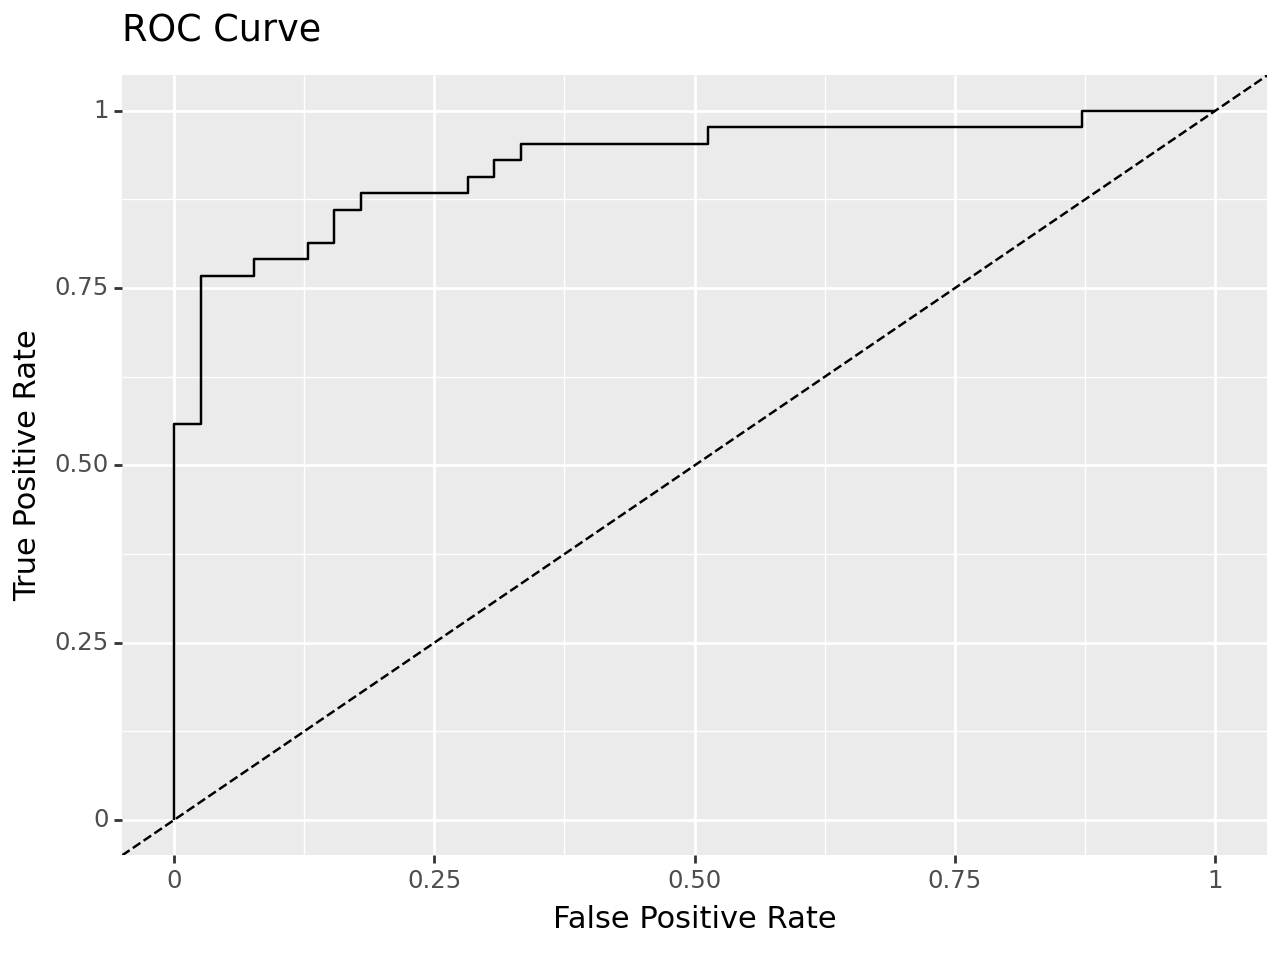

(array([[33,  6],
        [ 7, 36]]),
 <Figure Size: (640 x 480)>)

In [170]:
logr_conf_matrix, logr_roc_plot

## Q4 - interpretation

The predictors that were most important included the following: Chest Pain, Sex, Maximum heart rate achieved during exercise, resting blood pressure and cholesterol turned out to be the most importan coefficients.

In [171]:
coefficients = logr_best_model.named_steps['model'].coef_[0]
categorical_features = ['cp', 'restecg','sex']
numeric_features = ['age', 'trtbps', 'chol', 'thalach']

feature_names_transformed = (logr_best_model.named_steps['preprocessing']
                             .transformers_[0][1]
                             .get_feature_names_out(categorical_features))
feature_names = np.concatenate([feature_names_transformed, numeric_features])

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_importance

Feature  Coefficient
0        cp_0    -1.921131
1        cp_1     0.053641
2        cp_2     0.000000
3        cp_3     0.000000
4   restecg_0     0.000000
5   restecg_1     0.286616
6   restecg_2     0.000000
7       sex_0     1.419489
8       sex_1    -0.552505
9         age    -0.222200
10     trtbps    -0.324307
11       chol    -0.254972
12    thalach     0.757699

## Q5 - roc plots shown above below each model

# **Part Two: Metrics**

In [172]:
def metrics(model):
  X = ha.drop('output', axis=1)
  y = ha['output']

  accuracy = cross_val_score(model, X, y, cv = 5, scoring = 'accuracy').mean()

  precision = cross_val_score(model, X, y, cv = 5, scoring = 'precision').mean()

  recall = cross_val_score(model, X, y, cv = 5, scoring = 'recall').mean()

  return accuracy, precision, recall

In [173]:
def specificity_score(confusionmatrix):
    tn, fp, fn, tp = confusionmatrix.ravel()
    specificity = tn / (tn + fp)
    return specificity

In [174]:
knn_spec = specificity_score(knn_conf_matrix)
dt_spec = specificity_score(dt_conf_matrix)
logr_spec = specificity_score(logr_conf_matrix)


knn_accuracy, knn_precision, knn_recall = metrics(knn_best_model)
dt_accuracy, dt_precision, dt_recall = metrics(dt_best_model)
logr_accuracy, logr_precision, logr_recall = metrics(logr_best_model)

data = {
    'Model': ['KNN', 'Decision Tree', 'Logistic Regression'],
    'Accuracy': [knn_accuracy, dt_accuracy, logr_accuracy],
    'Precision': [knn_precision, dt_precision, logr_precision],
    'Recall': [knn_recall, dt_recall, logr_recall],
    'Specificity':[knn_spec, dt_spec, logr_spec]
}
metrics_df = pd.DataFrame(data)

metrics_df

Model  Accuracy  Precision    Recall  Specificity
0                  KNN  0.772862   0.822620  0.733333     0.846154
1        Decision Tree  0.776498   0.808768  0.760460     0.757576
2  Logistic Regression  0.783838   0.796513  0.815402     0.846154

# **Part Three: Discussion**

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

Which metric(s) you would use for model selection and why.

Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

## Q1 The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

  I would use recall metirc for model selection because that way it minimizes the numebr of missed diagnosis

  In this case i would recommend the logistic regression as it yielded the highest recall score.

  I would expect a score of 81.54% for this case

## Q2 The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

  I would use precision method as it emphasizes the trues positives that are identified. Focusing on the model that selects the most patients that are in risk of heart attacks and are diagnosed.

  For this case i would recommend the knn model for the hospital, this case yielded the highest precision score out of the three final models.

  I would expect a score of 82.26% for this model and this metric

## Q3 The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

  For this model i would choose accuracy as the method, because we want to look at mostly at the coefficients of the corrected diagnosed ptients.

  I would recommend the logistic regression, specially given it used mostly a lasso penalty, this way we can look at the coefficients for each variable as we did above and look at what variables are more important when diagnosing heart disease.

  I would expect a score of .7838 for this model and this metric.

## Q4 The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

  the accuracy should be used, it measures the accuracy or how many patients are diagnosed correct (whether it is a yes or a no for heart attack)

  Again fot this scenario i would recommend a logistic model as it provided me with the highest accuracy.

  I would expect a score of .7838 for this model and this metric.

# **Part Four: Validation**

In [175]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
X_val = ha_validation.drop('output', axis=1)
y_val = ha_validation['output']

In [176]:
def val_set(model):
  y_pred = model.predict(X_val)

  cm = confusion_matrix(y_val, y_pred)

  roc_auc = roc_auc_score(y_val, y_pred)
  precision = precision_score(y_val, y_pred)
  recall = recall_score(y_val, y_pred)
  kappa = cohen_kappa_score(y_val, y_pred)


  return cm, roc_auc, precision, recall, kappa

In [177]:
knn_conf_matrix, knn_rocauc, knn_precision, knn_recall, knn_kappa = val_set(knn_best_model)
dt_conf_matrix, dt_rocauc, dt_precision, dt_recall, dt_kappa = val_set(dt_best_model)
logr_conf_matrix, logr_rocauc, logr_precision, logr_recall, logr_kappa = val_set(logr_best_model)

data = {
    'Model': ['KNN', 'Decision Tree', 'Logistic Regression'],
    'Roc Auc': [knn_rocauc, dt_rocauc, logr_rocauc],
    'Precision': [knn_precision, dt_precision, logr_precision],
    'Recall': [knn_recall, dt_recall, logr_recall],
    "Cohen's Kappa":[knn_kappa, dt_kappa, logr_kappa]
}
metrics_df = pd.DataFrame(data)

metrics_df

Model   Roc Auc  Precision    Recall  Cohen's Kappa
0                  KNN  0.672249   0.833333  0.526316       0.303797
1        Decision Tree  0.724880   0.857143  0.631579       0.410480
2  Logistic Regression  0.777512   0.875000  0.736842       0.524887

In [178]:
knn_conf_matrix, dt_conf_matrix, logr_conf_matrix

(array([[ 9,  2],
        [ 9, 10]]),
 array([[ 9,  2],
        [ 7, 12]]),
 array([[ 9,  2],
        [ 5, 14]]))

When comparing these values to that of part 1 and two the success of the model from the initial data to the validation data are somwhat similar forlogistic regression, however we saw a big decline on the knn model. We also saw a slight decline in the success of the model for decision tree.

# **Part Five: Cohen’s Kappa**

We can look at the Cohen's Kappa scores on the table above.

This score wouldn't change much of my conclusions for the first three questions but it is very relevant on question 4, as we are testing for the agreement between two doctors and the model, checking if the chances that they could have came to the same conclusion was just by chance. With that said, that wouldn't change my conclusion since the highest cohen's kappa score is still the logistic regression. Cohens kappa is very important when agreement between two decision makers are crucial - doctor and model. This makes sense as it takes into account the "lucky aspect". a low kappa here could indicate that the model agrees with actual outcomes/diagnosis mostly by chance.